In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Solution to Exercise 6: Non-linear gravity inversion - Gradient Descent

Consider the exact same non-linear inverse problem and the associated gravimetric data of the previous exercise:

In [2]:
# Load data
dobs = np.loadtxt("data.dat")

# Define measurement positions, rho, G, and delta_gz
x = np.linspace(-50,50,50)
density = -3000 # cavity = decrease in density
G = 6.6743e-11 # gravitational constant

def grav(R, z):
    """Formula from the exercise sheet as a function for later reuse."""
    gz = 4/3 * np.pi * R**3 * density * G * z / (x**2 + z**2)**(3/2)
    gz *= 1e5 # unit conversion
    return gz

In the previous exercise, we followed a grid-search procedure, meaning that we tested different parameter combinations by "brute-force" and checked how well they describe our measurements. The best possible combination, i.e. the minimum of our objective function, is the final solution.

In [3]:
size=500
radii = np.linspace(1,30,size)
depth = np.linspace(1,50,size)

obj = np.zeros((size, size))
X, Y = np.meshgrid(radii, depth)

def objective(R, d):
    return np.sqrt(np.mean((dobs - grav(R, d))**2))
    
for i, R in enumerate(radii):
    for j, d in enumerate(depth):
        obj[j, i] = objective(R, d)
 
i, j = np.where(obj == obj.min())
rad_opt, depth_opt = X[i,j],Y[i,j]

### Visualizing the prediction error for all combinations of R and z

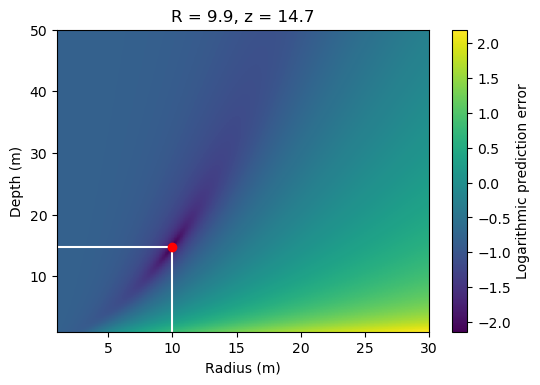

In [4]:
plt.figure(dpi=100)
plt.pcolor(X, Y, np.log10(obj))
plt.plot(rad_opt, depth_opt, "ro")
plt.vlines(rad_opt, 1, depth_opt, "w")
plt.hlines(depth_opt, 1, rad_opt, "w")
plt.title("R = %.1f, z = %.1f" % (rad_opt, depth_opt))
plt.xlabel("Radius (m)")
plt.ylabel("Depth (m)")
plt.colorbar(label="Logarithmic prediction error")

While this worked well and was relatively easy to implement (two for loops looping over the two parameters), it can be computationally prohibitive for real-work problems with hundreds or thousands of parameters and with a more complex forward problem (i.e., 3D simulation code rather than analytical formula). Today, we want to try a different, smarter approach.

# Gradient descent

As opposed to the global grid-search optimization shown above, [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is a local optimization scheme. This approach, or variants of it, are commonly used in non-linear geophysical inversion, but also in other areas such as the training of neural networks. The main advantage of this method, as opposed to a grid-search, is that it usually requires much fewer executions of the forward function/model, thereby significantly improving it's efficiency. That is because only a small subset of the model space is explored.

The iterative algorithm starts with an initial guess, the starting model. In each iteration step, the gradient of the objective function in each dimension (i.e., with respect to each model parameter) is calculated. Since analytical solutions to this are often unavailable, this is commonly achieved by finite-difference calculations, meaning that the model is slightly varied and we check how the resonse changes. This gradient indicates in which way the model parameters should change in order to decrease the objective function. The exact amount by which the parameters are modified in each step is determined by a step length parameter. This iterative process is repeated until the objective function does not notably change anymore or the number of maximum iterations it reached.

Note that this scheme can be quite dependent on the initial model: If there are several minima to the objective function, gradient descent will converge towards the one closest to the starting model.

Start by defining a central finite-difference approximation of the objective function's gradient (see the section on [relation with derivatives here](https://en.wikipedia.org/wiki/Finite_difference)) with respect to both model parameters (return a value for each!). The perturbation parameter $h$ should not change throughout the inversion and can be set to 0.1. Note that our objective function is a multi-variate function, meaning that it has two parameters (radius and depth). The gradient you need is:

$$\nabla \Psi(r,z) = \left[\frac{\partial}{\partial r} \Psi, \frac{\partial}{\partial z} \Psi\right]$$

Define a function that calculates the gradient (with central finite-differences) and returns it as a numpy array at a given pair of $r$ and $z$.

In [5]:
# Finite-difference approximation of the gradient
def gradient(x, y):
    h = .1
    grad_x = (objective(x + h, y) - objective(x - h, y))/(2*h)
    grad_y = (objective(x, y + h) - objective(x, y - h))/(2*h)
    return np.array([grad_x, grad_y])

Define a starting model with a radius of 25 m and a depth of 40 m. Calculate the gradient at this position. It should be approximately [0.06, -0.02].

In [6]:
start = [25, 40]
gradient(*start)

array([ 0.0644982 , -0.01997339])

Now you can implement the gradient descent. Define a starting model $m_0$, step-length $\alpha$ and the desired precision threshold. Model updates are calculated by multiplying the negative step length with the gradient. The procedure is as follows:

1. Current model equals starting model $m = m_0$

2. Calculate model update based on negative gradient $\Delta m = -\alpha \nabla\Psi(m)$

3. Update model $m = m + \Delta m$

4. Repeat from step 2

Start with a step length of $\alpha = 20$ and a maximum number of 1000 iterations. Visualize the current model estimate of each iteration on top of the figures of the grid search (as a simple point with `plt.plot`. Does your algorithm walk into the right direction? Does it reach the minimum?

Final iteration # 1500 : Model vector is [ 9.95753189 14.78337091]


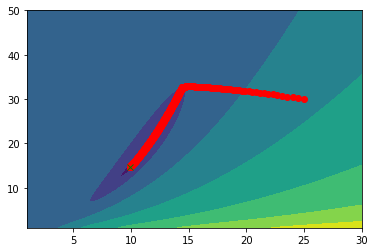

In [7]:
m_current = np.array([25.0, 30.0]) # starting model
alpha = 5# step length (bad: 0.95, good: 0.1)
precision = 0.05 # When to stop?
delta_m = np.array([1., 1.])
max_iters = 1500 # maximum number of iterations
it = 0 # iteration counter
error = 10

iterations = []
errors = []

fig, ax = plt.subplots()
ax.contourf(X, Y, np.log10(obj))

while error > precision and it < max_iters:
    ax.plot(m_current[0], m_current[1], "ro")
    iterations.append(it)
    
    delta_m = -alpha * gradient(*m_current)

    m_current += delta_m # Grad descent
    
    error = np.linalg.norm(dobs - grav(*m_current))
    errors.append(error)
        
    it += 1 # iteration count

rad_opt, depth_opt = m_current

ax.plot(rad_opt, depth_opt, "gx")

print("Final iteration #", it,": Model vector is", m_current)

Visualize the convergence by plotting your error (`np.linalg.norm(dobs - grav(r_k, z_k))` history against the iteration number $k$.

Text(0, 0.5, 'prediction error')

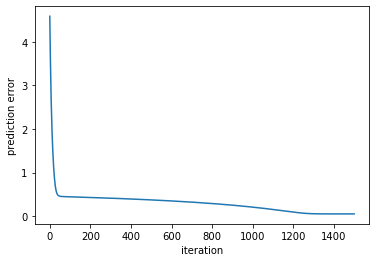

In [8]:
plt.plot(iterations, errors)
plt.xlabel('iteration')
plt.ylabel('prediction error')

Play with the step size $\alpha$. What is its effect?

---
**Bonus**:
    
Make a comparison of the timing. Is the gradient solution faster than the grid search? Note that for a fair comparison, you need to exclude the plotting part from the cells, as plotting can take quite some time.

Timing can be done with the Python built-in module `time` or by putting (`%%time`) in the first line of the cell you want to time.

In [9]:
import time

t = time.time()
time.sleep(2)
print(time.time() - t, "seconds elapsed.")

2.001985549926758 seconds elapsed.
